# Attempting a traditional NLP ML Model

## Set Up and Imports

In [26]:
# import general packages

from datetime import date
import pandas as pd
import numpy as np
import tweepy
import config
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import flatten_json as fj

# import text packages

import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer

# import ML classifier packages

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

In [2]:
# set up connection to api

auth = tweepy.OAuthHandler(config.ckey, config.csecret)
auth.set_access_token(config.atoken, config.asecret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

## Define functions

In [3]:
# cleaning function for tweets

def kleenex(var):
        #clean_tweet = []
        #for var in list_in:
        tmp = re.sub('(https://t.co/).*', ' ', var)
        tmp = re.sub('@.+?\s', ' ', tmp)
        tmp = re.sub('[^a-zA-Z]+', ' ', tmp)
        #tmp = re.sub('^(RT)', ' ', tmp)
        tmp = tmp.lower()
        tmp = re.sub('(vaccinesafety)', ' ', tmp)
        tmp = re.sub('(medicalfreedom)', ' ', tmp)
        tmp = re.sub('(vaccineswork)', ' ', tmp)
        tmp = re.sub('(vaccinessavelives)', ' ', tmp)
        #tmp = [word for word in tmp.split() if word not in stop_words]
        #tmp = ' '.join(tmp)
            #clean_tweet.append(tmp)
        return(tmp) #used to be clean_tweet

In [147]:
# function from https://stackoverflow.com/a/41919739/12065631
# I switched it up a bit to exclude RTs

def get_tweets(query, n):
    _max_queries = 1000000  # arbitrarily chosen value
    query = query + " -filter:retweets"

    tweets = tweet_batch = api.search(q = query, count = n, tweet_mode = "extended")
    final_list = []
    for status in tweet_batch:
        final_list.append(kleenex(status.full_text))  
    #tweets.extend(tweet_batch)
    
    ct = 1
    while len(tweets) < n and ct < _max_queries:
        #print(len(tweets))
        tweet_batch = api.search(q=query, 
                                 count=n - len(tweets),
                                 max_id=tweet_batch.max_id,
                                 tweet_mode = "extended")
        for status in tweet_batch:
            final_list.append(kleenex(status.full_text))
        tweets.extend(tweet_batch)
        ct += 1
        
    return final_list

In [4]:
# POS tagger for lemmatization

def get_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

In [5]:
# PCA reduction with min dimensions (didn't end up using)

def iterate_var(my_xform_tfidf_in, var_target, data_slice):
        """PCA using smallest possible # of components to hit target EVR"""
        print("Dimension reduction in progress! One moment, please!")
        var_fig = 0.0
        cnt = 1
        while var_fig <= var_target:
            pca = PCA(n_components=cnt)
            my_dim = pca.fit_transform(my_xform_tfidf_in[0:data_slice])
            var_fig = sum(pca.explained_variance_ratio_)   
            cnt += 1
        pca = PCA(n_components=cnt)
        my_dim = pca.fit_transform(my_xform_tfidf_in)

        return(my_dim, pca)

## Collect test/train data

In [84]:
# majority antivaxx hashtags: #medicalfreedom, #vaccinesafety
# majority provaxx hashtags: #vaccineswork, #vaccinessavelives
# NOTE: result_type = 'popular' majorly limits pull

#test = api.search("#medicalfreedom", lang = 'en', result_type = 'popular', count = 100)
#medicalfreedom = []
#vaccinesafety = []
#vaccineswork = []
#vaccinessavelives = []

#for status in tweepy.Cursor(api.search, q = '#medicalfreedom', lang = 'en', tweet_mode = 'extended', count = 100).items(100):
#    if not hasattr(status, 'retweeted_status'):
#        medicalfreedom.append(kleenex(status.full_text))

#for status in tweepy.Cursor(api.search, q = '#vaccinesafety', lang = 'en', tweet_mode = 'extended', count = 100).items(100):
#    if not hasattr(status, 'retweeted_status'):
#        vaccinesafety.append(kleenex(status.full_text))
    #except AttributeError:
        #vaccinesafety.append(kleenex(status.retweeted_status.full_text))

#for status in tweepy.Cursor(api.search, q = '#vaccineswork', lang = 'en', tweet_mode = 'extended', count = 100).items(100):
#    if not hasattr(status, 'retweeted_status'):
#        vaccineswork.append(kleenex(status.full_text))
        
#for status in tweepy.Cursor(api.search, q = '#vaccinessavelives', lang = 'en', tweet_mode = 'extended', count = 100).items(100):
#    if not hasattr(status, 'retweeted_status'):
#        vaccinessavelives.append(kleenex(status.full_text))

In [126]:
# majority antivaxx hashtags: #medicalfreedom, #vaccinesafety
# majority provaxx hashtags: #vaccineswork, #vaccinessavelives

medicalfreedom = get_tweets("#medicalfreedom", 200)
print(len(medicalfreedom))

vaccinesafety = get_tweets("#vaccinesafety", 200)
print(len(vaccinesafety))

vaccineswork = get_tweets("#vaccineswork", 200)
print(len(vaccineswork))

vaccinessavelives = get_tweets("#vaccinessavelives", 200)
print(len(vaccinessavelives))

200
200
200
200


In [127]:
# basic dataframe of text and label
# NOTE: 1 == 'antivaxx' and 0 == 'provaxx'

d_anti = pd.DataFrame({"text": medicalfreedom + vaccinesafety, "label": 1})
d_pro = pd.DataFrame({"text": vaccineswork + vaccinessavelives, "label": 0})

d = pd.concat([d_anti, d_pro])

In [128]:
# sanity checkkkkk

print(d.head())
print(d.tail())
print(len(d))

                                                text  label
0     what is your position on   and parentalrights       1
1           do they all defend parentalrights and         1
2   know your state vaccine exemptions how to opt...      1
3  guarantee amp protect   and informedconsent an...      1
4              notsafeoreffective exposebillgates         1
                                                  text  label
395  the waning of the anti vaccination movement an...      0
396  what vaccines should senior citizens receive h...      0
397  watching a video about hpv and cervicalcancer ...      0
398  the ausvaxsafety summary report has been relea...      0
399             vaccinesaretheanswer thankyouvaccines       0
800


In [129]:
# stem and lemma (with or without stop words)

stemmer = PorterStemmer()
lemmer = WordNetLemmatizer()

lemma = []
stem = []
lemma_sw = []
stem_sw = []

for com in d.text:
    tokenwrd = word_tokenize(com)
    tmp = [stemmer.stem(wrd) for wrd in tokenwrd]
    tmp2 = [lemmer.lemmatize(wrd, get_pos(wrd)) for wrd in tokenwrd]
    tmp3 = [stemmer.stem(wrd) for wrd in tokenwrd if wrd not in stop_words]
    tmp4 = [lemmer.lemmatize(wrd, get_pos(wrd)) for wrd in tokenwrd if wrd not in stop_words]
    stem.append(" ".join(tmp))
    lemma.append(" ".join(tmp2))
    stem_sw.append(" ".join(tmp3))
    lemma_sw.append(" ".join(tmp4))
    #stem.append(tmp)
    #lemma.append(tmp2)
    #stem_sw.append(tmp3)
    #lemma_sw.append(tmp4)
    
d["stem_sw"] = stem_sw
d["lemma_sw"] = lemma_sw
d['stem'] = stem
d['lemma'] = lemma

In [130]:
# Chop into test/train
X = d.loc[:,d.columns != "label"]
y = d["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [131]:
# vectorizing and n-grams for training datasets

count_vec = CountVectorizer()
tfidf_vec = TfidfVectorizer()
count_vec2 = CountVectorizer(ngram_range = (1,2))
tfidf_vec2 = TfidfVectorizer(ngram_range = (1,2))

# stop words removed and 1:1-gram

count_stem_sw_Xtrain = count_vec.fit_transform(X_train["stem_sw"])
count_stem_sw_Xtest = count_vec.transform(X_test["stem_sw"])
count_lemma_sw_Xtrain = count_vec.fit_transform(X_train["lemma_sw"])
count_lemma_sw_Xtest = count_vec.transform(X_test["lemma_sw"])
tfidf_stem_sw_Xtrain = tfidf_vec.fit_transform(X_train["stem_sw"])
tfidf_stem_sw_Xtest = tfidf_vec.transform(X_test["stem_sw"])
tfidf_lemma_sw_Xtrain = tfidf_vec.fit_transform(X_train["lemma_sw"])
tfidf_lemma_sw_Xtest = tfidf_vec.transform(X_test["lemma_sw"])

# stop words included and 1:2-gram

count_stem_2gram_Xtrain = count_vec2.fit_transform(X_train["stem"])
count_stem_2gram_Xtest = count_vec2.transform(X_test["stem"])
count_lemma_2gram_Xtrain = count_vec2.fit_transform(X_train["lemma"])
count_lemma_2gram_Xtest = count_vec2.transform(X_test["lemma"])
tfidf_stem_2gram_Xtrain = tfidf_vec2.fit_transform(X_train["stem"])
tfidf_stem_2gram_Xtest = tfidf_vec2.transform(X_test["stem"])
tfidf_lemma_2gram_Xtrain = tfidf_vec2.fit_transform(X_train["lemma"])
tfidf_lemma_2gram_Xtest = tfidf_vec2.transform(X_test["lemma"])


## K-Nearest Neighbors Models

In [132]:
# basic models (no grid search)

knn = KNeighborsClassifier()
knn.fit(count_stem_sw_Xtrain, y_train)
print("count stem sw accuracy: {:.2f}".format(knn.score(count_stem_sw_Xtest, y_test)))

knn.fit(count_stem_2gram_Xtrain, y_train)
print("count stem 2gram accuracy: {:.2f}".format(knn.score(count_stem_2gram_Xtest, y_test)))

knn.fit(count_lemma_sw_Xtrain, y_train)
print("count lemma sw accuracy: {:.2f}".format(knn.score(count_lemma_sw_Xtest, y_test)))

knn.fit(count_lemma_2gram_Xtrain, y_train)
print("count lemma 2gram accuracy: {:.2f}".format(knn.score(count_lemma_2gram_Xtest, y_test)))

knn.fit(tfidf_stem_sw_Xtrain, y_train)
print("tfidf stem sw accuracy: {:.2f}".format(knn.score(tfidf_stem_sw_Xtest, y_test)))

knn.fit(tfidf_stem_2gram_Xtrain, y_train)
print("tfidf stem 2gram accuracy: {:.2f}".format(knn.score(tfidf_stem_2gram_Xtest, y_test)))

knn.fit(tfidf_lemma_sw_Xtrain, y_train)
print("tfidf lemma sw accuracy: {:.2f}".format(knn.score(tfidf_lemma_sw_Xtest, y_test)))

knn.fit(tfidf_lemma_2gram_Xtrain, y_train)
print("tfidf lemma 2gram accuracy: {:.2f}".format(knn.score(tfidf_lemma_2gram_Xtest, y_test)))

count stem sw accuracy: 0.69
count stem 2gram accuracy: 0.69
count lemma sw accuracy: 0.69
count lemma 2gram accuracy: 0.67
tfidf stem sw accuracy: 0.69
tfidf stem 2gram accuracy: 0.73
tfidf lemma sw accuracy: 0.69
tfidf lemma 2gram accuracy: 0.68


In [72]:
# KNN grid search using most accurate simple model
# NOTE: Winner is tfidf lemma 2gram: 0.83 accuracy

met_grid= ['accuracy', 'f1']

knn_params = {"n_neighbors": np.arange(1, 21, 2),
             "weights": ["uniform", "distance"]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid = knn_params, cv = 10, scoring = met_grid, 
                       refit = 'accuracy', return_train_score = True)
knn_grid.fit(tfidf_lemma_2gram_Xtrain, y_train)

print("best mean cross-validation accuracy: {:.3f}".format(knn_grid.best_score_))
print("all cross-validation f1-scores: {}".format(knn_grid.cv_results_['mean_test_f1']))
print("best parameters: {}".format(knn_grid.best_params_))
print("test-set accuracy: {:.3f}".format(knn_grid.score(tfidf_lemma_2gram_Xtest, y_test)))

best mean cross-validation accuracy: 0.886
all cross-validation f1-scores: [0.19779842 0.19779842 0.53698818 0.55123705 0.43028977 0.46227175
 0.38432772 0.43431342 0.34291134 0.40164906 0.30485994 0.35859435
 0.26135023 0.32189363 0.23692565 0.3031594  0.18359231 0.25556512
 0.15532164 0.22916654]
best parameters: {'n_neighbors': 3, 'weights': 'distance'}
test-set accuracy: 0.865


## Random Forest Models

In [133]:
# basic models (no grid search)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(count_stem_sw_Xtrain, y_train)
print("count stem sw accuracy: {:.2f}".format(rfc.score(count_stem_sw_Xtest, y_test)))

rfc.fit(count_stem_2gram_Xtrain, y_train)
print("count stem 2gram accuracy: {:.2f}".format(rfc.score(count_stem_2gram_Xtest, y_test)))

rfc.fit(count_lemma_sw_Xtrain, y_train)
print("count lemma sw accuracy: {:.2f}".format(rfc.score(count_lemma_sw_Xtest, y_test)))

rfc.fit(count_lemma_2gram_Xtrain, y_train)
print("count lemma 2gram accuracy: {:.2f}".format(rfc.score(count_lemma_2gram_Xtest, y_test)))

rfc.fit(tfidf_stem_sw_Xtrain, y_train)
print("tfidf stem sw accuracy: {:.2f}".format(rfc.score(tfidf_stem_sw_Xtest, y_test)))

rfc.fit(tfidf_stem_2gram_Xtrain, y_train)
print("tfidf stem 2gram accuracy: {:.2f}".format(rfc.score(tfidf_stem_2gram_Xtest, y_test)))

rfc.fit(tfidf_lemma_sw_Xtrain, y_train)
print("tfidf lemma sw accuracy: {:.2f}".format(rfc.score(tfidf_lemma_sw_Xtest, y_test)))

rfc.fit(tfidf_lemma_2gram_Xtrain, y_train)
print("tfidf lemma 2gram accuracy: {:.2f}".format(rfc.score(tfidf_lemma_2gram_Xtest, y_test)))

count stem sw accuracy: 0.88
count stem 2gram accuracy: 0.90
count lemma sw accuracy: 0.89
count lemma 2gram accuracy: 0.90
tfidf stem sw accuracy: 0.89
tfidf stem 2gram accuracy: 0.85
tfidf lemma sw accuracy: 0.88
tfidf lemma 2gram accuracy: 0.86


In [134]:
# grid search
#NOTE: winner is tfidf lemma sw: 0.89 (tied with tfidf stem sw)

rfc_params = {"n_estimators": np.arange(10, 101, 10),
             #"max_depth": np.arange(1, 11, 1),
             #"max_features": np.arange(1, 11, 1),
             "criterion": ["gini", "entropy"],
             "random_state": [42]}
rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid = rfc_params, cv = 10, scoring = met_grid, 
                       refit = 'accuracy', return_train_score = True)
rfc_grid.fit(tfidf_lemma_sw_Xtrain, y_train)

print("best mean cross-validation accuracy: {:.3f}".format(rfc_grid.best_score_))
print("all cross-validation f1-scores: {}".format(rfc_grid.cv_results_['mean_test_f1']))
print("best parameters: {}".format(rfc_grid.best_params_))
print("test-set accuracy: {:.3f}".format(rfc_grid.score(tfidf_lemma_sw_Xtest, y_test)))

best mean cross-validation accuracy: 0.882
all cross-validation f1-scores: [0.83712715 0.8586485  0.86740329 0.86003114 0.86953559 0.86591737
 0.86102624 0.8650257  0.87035623 0.86930985 0.85891116 0.87034456
 0.87216902 0.86558736 0.86555002 0.86522737 0.86273449 0.86510289
 0.86597    0.86969475]
best parameters: {'criterion': 'gini', 'n_estimators': 50, 'random_state': 42}
test-set accuracy: 0.880


## Support Vector Models

In [135]:
# basic models (no grid search)

svc = SVC(random_state=42)
svc.fit(count_stem_sw_Xtrain, y_train)
print("count stem sw accuracy: {:.2f}".format(svc.score(count_stem_sw_Xtest, y_test)))

svc.fit(count_stem_2gram_Xtrain, y_train)
print("count stem 2gram accuracy: {:.2f}".format(svc.score(count_stem_2gram_Xtest, y_test)))

svc.fit(count_lemma_sw_Xtrain, y_train)
print("count lemma sw accuracy: {:.2f}".format(svc.score(count_lemma_sw_Xtest, y_test)))

svc.fit(count_lemma_2gram_Xtrain, y_train)
print("count lemma 2gram accuracy: {:.2f}".format(svc.score(count_lemma_2gram_Xtest, y_test)))

svc.fit(tfidf_stem_sw_Xtrain, y_train)
print("tfidf stem sw accuracy: {:.2f}".format(svc.score(tfidf_stem_sw_Xtest, y_test)))

svc.fit(tfidf_stem_2gram_Xtrain, y_train)
print("tfidf stem 2gram accuracy: {:.2f}".format(svc.score(tfidf_stem_2gram_Xtest, y_test)))

svc.fit(tfidf_lemma_sw_Xtrain, y_train)
print("tfidf lemma sw accuracy: {:.2f}".format(svc.score(tfidf_lemma_sw_Xtest, y_test)))

svc.fit(tfidf_lemma_2gram_Xtrain, y_train)
print("tfidf lemma 2gram accuracy: {:.2f}".format(svc.score(tfidf_lemma_2gram_Xtest, y_test)))

count stem sw accuracy: 0.86
count stem 2gram accuracy: 0.82
count lemma sw accuracy: 0.85
count lemma 2gram accuracy: 0.83
tfidf stem sw accuracy: 0.91
tfidf stem 2gram accuracy: 0.90
tfidf lemma sw accuracy: 0.91
tfidf lemma 2gram accuracy: 0.89


In [136]:
# you guessed it, another grid search!
# NOTE: winner is tfidf lemma sw: 0.88

svc_params = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             "kernel": ["rbf", "linear", "poly", "sigmoid"],
             "random_state": [42]}
svc_grid = GridSearchCV(SVC(), param_grid = svc_params, cv = 10, scoring = met_grid, 
                       refit = 'accuracy', return_train_score = True)
svc_grid.fit(tfidf_lemma_sw_Xtrain, y_train)

print("best mean cross-validation accuracy: {:.3f}".format(svc_grid.best_score_))
print("all cross-validation f1-scores: {}".format(svc_grid.cv_results_['mean_test_f1']))
print("best parameters: {}".format(svc_grid.best_params_))
print("test-set accuracy: {:.3f}".format(svc_grid.score(tfidf_lemma_sw_Xtest, y_test)))

best mean cross-validation accuracy: 0.915
all cross-validation f1-scores: [0.66959707 0.66959707 0.66959707 0.66959707 0.66959707 0.66959707
 0.66959707 0.66959707 0.66964702 0.79094372 0.67341787 0.78424446
 0.89865409 0.91037909 0.69668234 0.90675695 0.91068506 0.87557706
 0.67029121 0.88980084 0.91068506 0.86318337 0.66476777 0.86817699
 0.91068506 0.86318337 0.66476777 0.86817699]
best parameters: {'C': 10, 'kernel': 'rbf', 'random_state': 42}
test-set accuracy: 0.905


## Logistic Regression Models

In [139]:
# basic penalized (l2) logistic regression

logreg = LogisticRegression(random_state=42)
logreg.fit(count_stem_sw_Xtrain, y_train)
print("count stem sw accuracy: {:.2f}".format(logreg.score(count_stem_sw_Xtest, y_test)))

logreg.fit(count_stem_2gram_Xtrain, y_train)
print("count stem 2gram accuracy: {:.2f}".format(logreg.score(count_stem_2gram_Xtest, y_test)))

logreg.fit(count_lemma_sw_Xtrain, y_train)
print("count lemma sw accuracy: {:.2f}".format(logreg.score(count_lemma_sw_Xtest, y_test)))

logreg.fit(count_lemma_2gram_Xtrain, y_train)
print("count lemma 2gram accuracy: {:.2f}".format(logreg.score(count_lemma_2gram_Xtest, y_test)))

logreg.fit(tfidf_stem_sw_Xtrain, y_train)
print("tfidf stem sw accuracy: {:.2f}".format(logreg.score(tfidf_stem_sw_Xtest, y_test)))

logreg.fit(tfidf_stem_2gram_Xtrain, y_train)
print("tfidf stem 2gram accuracy: {:.2f}".format(logreg.score(tfidf_stem_2gram_Xtest, y_test)))

logreg.fit(tfidf_lemma_sw_Xtrain, y_train)
print("tfidf lemma sw accuracy: {:.2f}".format(logreg.score(tfidf_lemma_sw_Xtest, y_test)))

logreg.fit(tfidf_lemma_2gram_Xtrain, y_train)
print("tfidf lemma 2gram accuracy: {:.2f}".format(logreg.score(tfidf_lemma_2gram_Xtest, y_test)))

count stem sw accuracy: 0.89
count stem 2gram accuracy: 0.86
count lemma sw accuracy: 0.89
count lemma 2gram accuracy: 0.87
tfidf stem sw accuracy: 0.90
tfidf stem 2gram accuracy: 0.88
tfidf lemma sw accuracy: 0.90
tfidf lemma 2gram accuracy: 0.88


In [140]:
# yet more grid searching
#NOTE: winner is count lemma sw: 0.89

logreg_params = {"C": [1, 10, 100, 1000],
             "penalty": ["l1", "l2"],
             "solver": ["liblinear", "saga"],
             "max_iter": [100000],
             "random_state": [42]}
logreg_grid = GridSearchCV(LogisticRegression(), param_grid = logreg_params, cv = 10, scoring = met_grid, 
                       refit = 'accuracy', return_train_score = True)
logreg_grid.fit(count_lemma_sw_Xtrain, y_train)

print("best mean cross-validation accuracy: {:.3f}".format(logreg_grid.best_score_))
print("all cross-validation f1-scores: {}".format(logreg_grid.cv_results_['mean_test_f1']))
print("best parameters: {}".format(logreg_grid.best_params_))
print("test-set accuracy: {:.3f}".format(logreg_grid.score(count_lemma_sw_Xtest, y_test)))

best mean cross-validation accuracy: 0.917
all cross-validation f1-scores: [0.84400243 0.84185957 0.91467743 0.91314738 0.88378556 0.8801941
 0.90775765 0.9096167  0.87553377 0.89656252 0.89992349 0.9016644
 0.88987506 0.9016644  0.89552611 0.89866542]
best parameters: {'C': 1, 'max_iter': 100000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
test-set accuracy: 0.890


## Data Visualizations (Heatmaps)

In [141]:
# heatmap prep (predictions)

knn_ypred = KNeighborsClassifier(**knn_grid.best_params_).fit(tfidf_lemma_2gram_Xtrain, y_train).predict(tfidf_lemma_2gram_Xtest)
rfc_ypred = RandomForestClassifier(**rfc_grid.best_params_).fit(tfidf_lemma_sw_Xtrain, y_train).predict(tfidf_lemma_sw_Xtest)
svc_ypred = SVC(**svc_grid.best_params_).fit(tfidf_lemma_sw_Xtrain, y_train).predict(tfidf_lemma_sw_Xtest)
logreg_ypred = LogisticRegression(**logreg_grid.best_params_).fit(count_lemma_sw_Xtrain, y_train).predict(count_lemma_sw_Xtest)

([<matplotlib.axis.YTick at 0x1c69e7d5708>,
 <a list of 2 Text yticklabel objects>)

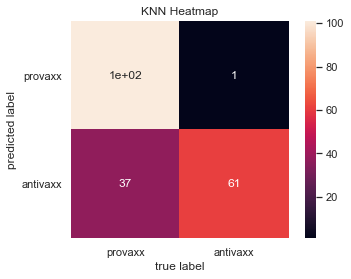

In [142]:
# knn heatmap

mat = confusion_matrix(y_test, knn_ypred)
sns.heatmap(mat, square=True, annot=True)
plt.title("KNN Heatmap")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.xticks(ticks = [0.5,1.5], labels = ["provaxx", "antivaxx"])
plt.yticks(ticks = [0.5,1.5], labels = ["provaxx", "antivaxx"], rotation = 0)

([<matplotlib.axis.YTick at 0x1c6a7762fc8>,
 <a list of 2 Text yticklabel objects>)

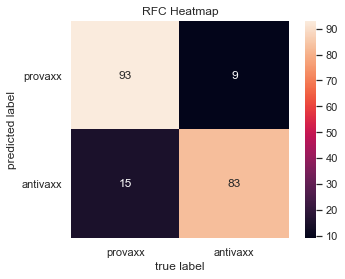

In [143]:
# rfc heatmap

mat = confusion_matrix(y_test, rfc_ypred)
sns.heatmap(mat, square=True, annot=True)
plt.title("RFC Heatmap")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.xticks(ticks = [0.5,1.5], labels = ["provaxx", "antivaxx"])
plt.yticks(ticks = [0.5,1.5], labels = ["provaxx", "antivaxx"], rotation = 0)

([<matplotlib.axis.YTick at 0x1c6a7780a08>,
 <a list of 2 Text yticklabel objects>)

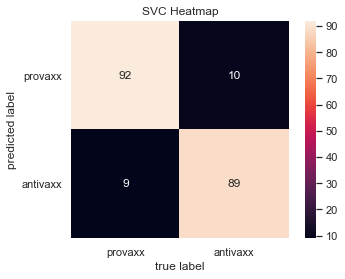

In [144]:
# svc heatmap

mat = confusion_matrix(y_test, svc_ypred)
sns.heatmap(mat, square=True, annot=True)
plt.title("SVC Heatmap")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.xticks(ticks = [0.5,1.5], labels = ["provaxx", "antivaxx"])
plt.yticks(ticks = [0.5,1.5], labels = ["provaxx", "antivaxx"], rotation = 0)

([<matplotlib.axis.YTick at 0x1c6a777f348>,
 <a list of 2 Text yticklabel objects>)

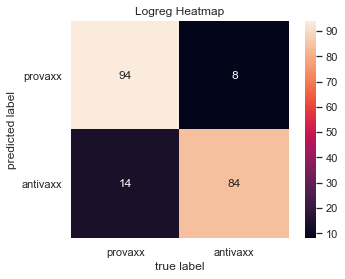

In [145]:
# logreg heatmap

mat = confusion_matrix(y_test, logreg_ypred)
sns.heatmap(mat, square=True, annot=True)
plt.title("Logreg Heatmap")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.xticks(ticks = [0.5,1.5], labels = ["provaxx", "antivaxx"])
plt.yticks(ticks = [0.5,1.5], labels = ["provaxx", "antivaxx"], rotation = 0)

## write dataset to csv

In [146]:
# sorry this is at the end, just thought of it lol

now = str(date.today())

d.to_csv("thesis_NLP_ML_data_{}.csv".format(now), index = False)

# Notes

Looks good so far! Next steps might be...

1. Test model on data that doesn't come from the initial scrape, ex. a new provaxx/antivaxx hashtag
2. Consider expanding the test/train dataset to include more tweets (worried abt rate limiting)
3. Fix incomplete node collection on target tweets
4. Use model on nodes (I'm leaning towards the penalized logistic regression) before and after retweeting target tweet
5. Consider if NLP should be on target tweet level and SNA should be on the pro/anti level?